In [86]:
import scipy.io

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd

import numpy as np

from game import Game
from strategies import FastAttractorMemory, BaseStrategy, PerfectMemory
from memory import FastAttractor

import torch
from tqdm import tqdm

from fiftyone import ViewField as F

import math

In [87]:
n_trials = 20

steps = 10

size_range = [[3,3], [4,4], [5,5], [6,6], [7,7]]

In [88]:
def play_strategy(strategy, game, max_steps=1500):
    win = False
    steps = 0
    while not win and steps < max_steps:
        strategy.pick()
        win = game.check_win()
        torch.cuda.empty_cache()
        steps+=1

In [89]:
def collect_data(n_trials, size_range, strategy, game):
    dfs = []
    tot_clicks = []
    for size in size_range:
        size_clicks = []
        for n in tqdm(range(n_trials), desc=f'Size: {size}'):
            game.set_size(size, 2)
            strategy.reset()
            play_strategy(strategy, game)
            df, nc = game.get_metrics()
            dfs.append(df)
            size_clicks.append(nc)
        tot_clicks.append(size_clicks)
    return pd.concat(dfs).reset_index(drop=True), tot_clicks

In [90]:
def add_reaction_times(activation_history, df):
    tiles_clicked = df['tile_clicked'].to_numpy()
    indices = np.repeat([True, True, False], (len(tiles_clicked) // 2)*steps)
    history = activation_history[indices]
    neuron = np.repeat(df['tile_clicked'].to_numpy(), steps)
    x = history[torch.arange(history.size(0)), neuron].view(-1, 10)
    max_v, _ = torch.max(x, dim=1, keepdim=True)
    df['reaction_time'] = np.argmax(torch.abs(max_v - x) <= torch.abs(0.1*max_v), axis=1)
    return df

In [91]:
def collect_data_attractor(n_trials, size_range, game, lr, rr, gx, gh):
    dfs = []
    tot_clicks = []
    for size in size_range: 
        size_clicks = []
        for n in tqdm(range(n_trials), desc=f'Size: {size}'):
            game.set_size(size, 2)
            dim = np.prod(size) + len(np.unique(game.get_grid_labels()))
            memory = FastAttractor(dim, lr, rr, gx, gh)
            strategy = FastAttractorMemory(game, memory, steps=steps)
            play_strategy(strategy, game)
            history = memory.get_activation_history()
            df, nc = game.get_metrics()
            df = add_reaction_times(history, df)
            dfs.append(df)
            size_clicks.append(nc)
        tot_clicks.append(size_clicks)
    return pd.concat(dfs).reset_index(drop=True), tot_clicks

In [92]:
def get_second_click_df(df):
    o_df = pd.DataFrame()
    o_df['match'] = df['match'].to_numpy()[1::2]
    o_df['random_match'] = df['random_match'].to_numpy()[1::2]
    o_df['board_size'] = df['board_size'].to_numpy()[1::2]
    o_df['tile_clicked'] = df['tile_clicked'].to_numpy()[1::2]
    o_df['nslc'] = df['nslc'].to_numpy()[1::2]
    o_df['nsp'] = df['nsp'].to_numpy()[1::2]
    o_df['correct_tile'] = df['correct_tile'].to_numpy()[0::2]
    o_df['reaction_time'] = df['reaction_time'].to_numpy()[1::2]
    return o_df

In [93]:
def build_nc_df(nc, strategy):
    data = []
    for i, size in enumerate(size_range):
        for j in range(n_trials):
            data.append({'size': str(size[0]), 'nc': math.log10(nc[i][j]/np.prod(size))})
    data = pd.DataFrame(data)
    data['strategy'] = strategy
    return data

In [94]:
game = Game(
            dataset_name='coco-2017', 
            split='validation', 
            field="ground_truth", 
            ds_filter=F("supercategory").is_in(('person', 'animal', 'food', 'vehicle', 'indoor')),
            dataset_dir ="/home/ravi/datasets/coco-2017",
        )

Found annotations at '/home/ravi/datasets/coco-2017/raw/instances_val2017.json'
Images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


# Benchmarks

In [95]:
bs = BaseStrategy(game)
bs_df, bs_nc = collect_data(n_trials, size_range, bs, game)
bs_nc_df = build_nc_df(bs_nc, 'Random Memory')
bs_df['strategy'] = 'Random memory'

Size: [7, 7]: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]


In [96]:
pm = PerfectMemory(game)
pm_df, pm_nc = collect_data(n_trials, size_range, pm, game)
pm_nc_df = build_nc_df(pm_nc, 'Perfect Memory')
pm_df['strategy'] = 'Perfect memory'

Size: [7, 7]: 100%|██████████| 20/20 [00:06<00:00,  2.87it/s]


# Attractor

In [97]:
att_df, att_nc = collect_data_attractor(n_trials, size_range, game, 0.6, 0.85, 0.75, 0.55)
att_df = get_second_click_df(att_df)
att_nc_df = build_nc_df(att_nc, 'Attractor Memory')
att_df['strategy'] = 'Attractor Memory'

Size: [7, 7]: 100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


# Behavioral metrics

In [98]:
df = att_df
df['Trial'] = 'Mismatch'
df.loc[df['match'] == 1, 'Trial'] = 'Match'
df['board_size'] = df['board_size'].apply(np.sqrt)

## Reaction Time

<Figure size 800x1600 with 0 Axes>

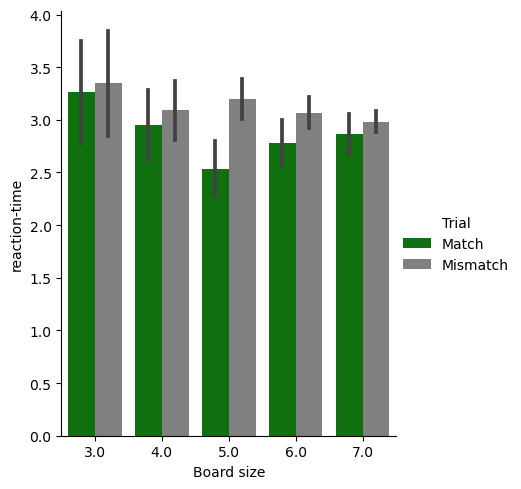

In [99]:
plt.figure(figsize=(8, 16))
palette = ['green', 'grey']
# Draw a nested barplot by species and sex
ax = sns.catplot(x="board_size", y="reaction_time", hue='Trial', data=df, aspect=0.85, kind='bar', errorbar='se', palette=palette, hue_order=['Match', 'Mismatch'])
ax.set(xlabel="Board size", ylabel="reaction-time")
plt.show()

## nsp

<Figure size 800x1600 with 0 Axes>

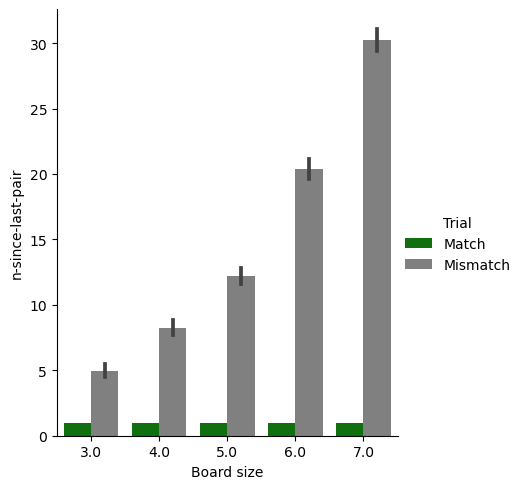

In [100]:
plt.figure(figsize=(8, 16))
palette = ['green', 'grey']
# Draw a nested barplot by species and sex
ax = sns.catplot(x="board_size", y="nsp", hue='Trial', data=df[df['nsp'] > 0], aspect=0.85, errorbar='se', kind='bar', palette=palette, hue_order=['Match', 'Mismatch'])
ax.set(xlabel="Board size", ylabel="n-since-last-pair")
plt.show()

## NSLC

<Figure size 800x1600 with 0 Axes>

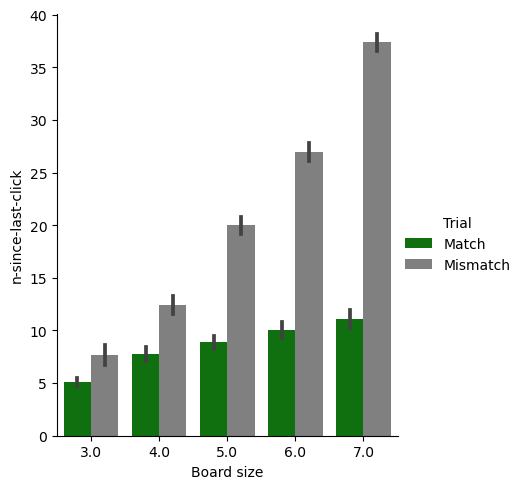

In [101]:
plt.figure(figsize=(8, 16))
palette = ['green', 'grey']
# Draw a nested barplot by species and sex
ax = sns.catplot(x="board_size", y="nslc", hue='Trial', data=df[df['nslc'] > 0], aspect=0.85, errorbar='se', kind='bar', palette=palette, hue_order=['Match', 'Mismatch'])
ax.set(xlabel="Board size", ylabel="n-since-last-click")
plt.show()

## Tot clicks

<Figure size 800x1600 with 0 Axes>

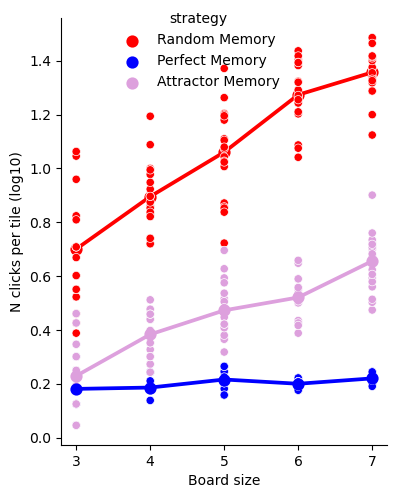

In [102]:
data = pd.concat([bs_nc_df, pm_nc_df, att_nc_df])
plt.figure(figsize=(8, 16))
palette = ['red', 'blue', 'plum']
ax2 = sns.catplot(x="size", y='nc', hue="strategy", data=data, aspect=0.85, errorbar=None, kind='point', palette=palette)
ax = sns.scatterplot(x="size", y='nc', hue="strategy", data=data, legend=False, palette=palette)
ax.set_xlabel("Board size")
ax.set_ylabel("N clicks per tile (log10)")
sns.move_legend(ax2, "upper center")

# Memory history

In [103]:
def plot_history(locations, category):
    # create a 3 X 2 grid 
    fig = plt.figure(figsize=(24, 10))
    gs = grd.GridSpec(3, 2, figure=fig, height_ratios=[len(locations),len(locations),len(category)], width_ratios=[18,1], wspace=0.4)
    # image plot
    ax1 = plt.subplot(gs[1,0])
    p1 = ax1.imshow(locations, aspect='auto', interpolation='none', cmap='hot')
    colorAx1 = plt.subplot(gs[1,1])
    cb1 = plt.colorbar(p1, cax = colorAx1)
    # image plot
    ax2 = plt.subplot(gs[2,0])
    p2 = ax2.imshow(category, aspect='auto', interpolation='none', cmap='hot')
    colorAx2 = plt.subplot(gs[2,1])
    cb2 = plt.colorbar(p2, cax = colorAx2)
    
    plt.show()

In [104]:
size = [3,3]
game.set_size(size, 2)
pos_f = np.prod(size)
lab_f = len(np.unique(game.get_grid_labels()))
dim = pos_f + lab_f
memory = FastAttractor(dim, lr=0.5, rr=0.95)
strategy = FastAttractorMemory(game, memory, steps=steps)
print(game.get_grid_labels())
print(np.arange(9))
tot = play_strategy(strategy, game)
print(tot)
ah = memory.get_activation_history()
plot_history(ah[:, :pos_f].T, ah[:, pos_f:].T)

TypeError: __init__() missing 2 required positional arguments: 'xg' and 'hg'

In [ ]:
plt.plot(memory.get_energy_history())

: 

: 

: 

: 

: 

In [ ]:
df, tot_clicks = game.get_metrics()
df['nslc'].to_numpy()
events_dict = {'probe': 'blue', 'response': 'red', 'delay': 'pink', 'stimulus': 'green'}
plot_history(f.T[:9], f.T[10:19], c, strategy.t_steps, strategy.events, events_dict)

: 

: 

: 

: 

: 